<a href="https://colab.research.google.com/github/swardiantara/ner-drone/blob/main/NER_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/ner-drone/ner_drone_train_2.csv'
data_test_path = '/content/drive/MyDrive/Colab Notebooks/ner-drone/ner_drone_test.csv'
dataset_train = pd.read_csv(dataset_path, encoding= 'unicode_escape')
dataset_test = pd.read_csv(data_test_path, encoding= 'unicode_escape')
dataset_train.shape

(3678, 3)

In [50]:
dataset_train

,sentence_idx,tokenized,tag
0,1,Taking,B-ACT
1,1,Off,I-ACT
2,2,Taking,B-ACT
3,2,Off,I-ACT
4,3,Taking,B-ACT
...,...,...,...
3673,672,will,O
3674,672,be,O
3675,672,disabled,O
3676,672,in,O


In [51]:
dataset_test

,sentence_idx,word,tag
0,1,Taking,B-ACT
1,1,Off,I-ACT
2,2,Home,B-ISS
3,2,Point,I-ISS
4,2,Recorded,O
...,...,...,...
787,90,Controller,B-CMP
788,90,Settings,B-FNC
789,90,after,O
790,90,cancelling,O


In [52]:
dataset_train['tag'].value_counts()

O        2692
B-FNC     329
B-CMP     149
B-ACT     141
I-ISS      80
B-STE      73
B-ISS      66
I-STE      45
I-FNC      40
I-ACT      36
I-CMP      27
Name: tag, dtype: int64

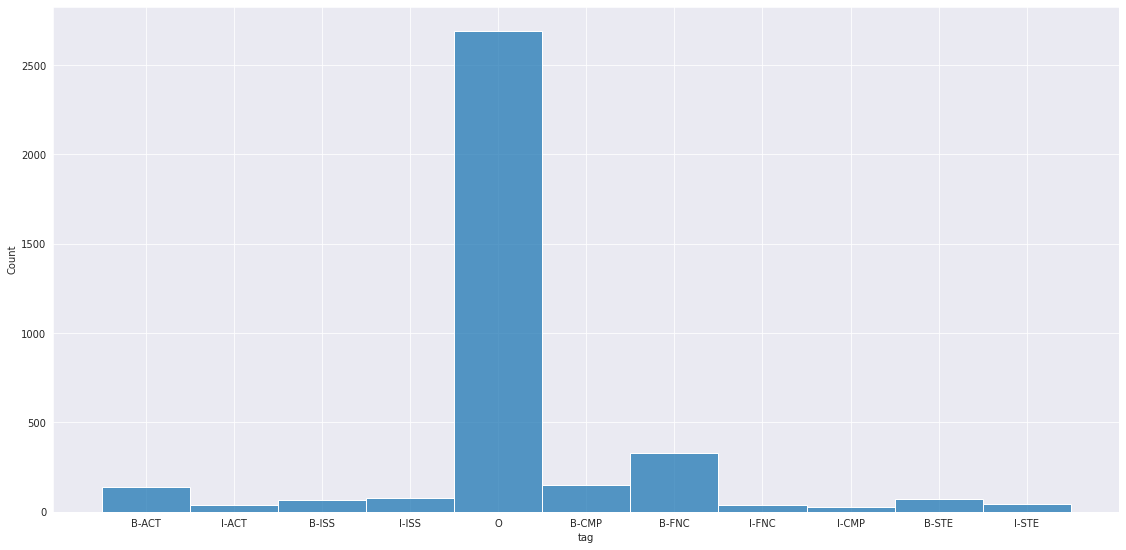

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(dataset_train['tag'])
plt.tight_layout(pad=2)
plt.show()

In [40]:
dataset_test['tag'].value_counts()

O        620
B-CMP     52
B-ACT     33
B-ISS     17
I-ISS     17
B-FNC     17
I-CMP     10
B-STE      9
I-STE      9
I-FNC      7
I-ACT      1
Name: tag, dtype: int64

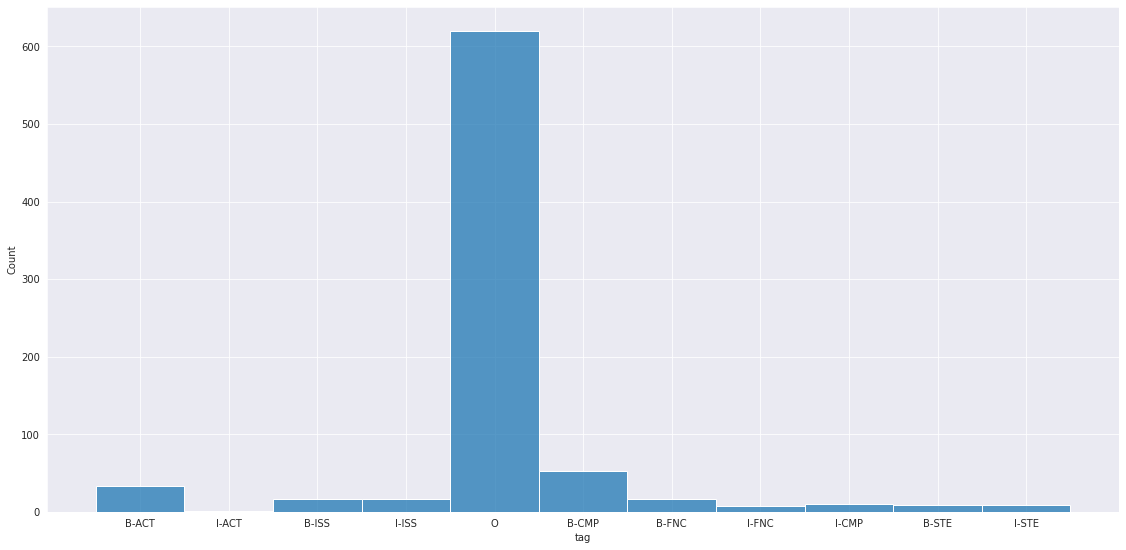

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(dataset_test['tag'])
plt.tight_layout(pad=2)
plt.show()

In [56]:
from itertools import chain
def get_dict_map(dataset, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(dataset['tokenized'].to_list()))
    else:
        vocab = list(set(dataset['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok, vocab
token2idx, idx2token, token_vocab = get_dict_map(dataset_train, 'token')
tag2idx, idx2tag, tag_vocab = get_dict_map(dataset_train, 'tag')

In [57]:
print(tag2idx)

{'B-STE': 0, 'I-ISS': 1, 'I-STE': 2, 'B-ISS': 3, 'I-ACT': 4, 'B-CMP': 5, 'I-FNC': 6, 'O': 7, 'B-FNC': 8, 'I-CMP': 9, 'B-ACT': 10}


In [58]:
# Set index 0 for tag O
tag2idx['B-STE'] = 7
idx2tag[7] = 'B-STE'
idx2tag[0] = 'O'
tag2idx['O'] = 0

In [59]:
print(tag2idx)
print(idx2tag)

{'B-STE': 7, 'I-ISS': 1, 'I-STE': 2, 'B-ISS': 3, 'I-ACT': 4, 'B-CMP': 5, 'I-FNC': 6, 'O': 0, 'B-FNC': 8, 'I-CMP': 9, 'B-ACT': 10}
{0: 'O', 1: 'I-ISS', 2: 'I-STE', 3: 'B-ISS', 4: 'I-ACT', 5: 'B-CMP', 6: 'I-FNC', 7: 'B-STE', 8: 'B-FNC', 9: 'I-CMP', 10: 'B-ACT'}


In [60]:
# Data Train
dataset_fillna_train = dataset_train.fillna(method='ffill', axis=0)
dataset_group_train = dataset_fillna_train.groupby(['sentence_idx'], as_index=False)['tokenized', 'tag'].agg(lambda x: list(x))

# Data Test
dataset_fillna_test = dataset_test.fillna(method='ffill', axis=0)
dataset_group_test = dataset_fillna_test.groupby(['sentence_idx'], as_index=False)['word', 'tag'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [61]:
dataset_group_train

,sentence_idx,tokenized,tag
0,1,"[Taking, Off]","[B-ACT, I-ACT]"
1,2,"[Taking, Off]","[B-ACT, I-ACT]"
2,3,"[Taking, Off]","[B-ACT, I-ACT]"
3,4,"[Taking, Off]","[B-ACT, I-ACT]"
4,5,"[Home, Point, Recorded, RTH, Altitude, 30m]","[B-ISS, I-ISS, O, B-ACT, O, O]"
...,...,...,...
667,668,"[Taking, Off]","[B-ACT, I-ACT]"
668,669,"[Home, Point, Recorded, RTH, Altitude, 30m]","[O, O, O, B-ACT, O, O]"
669,670,"[Tap, the, screen, lightly, to, focus]","[O, O, O, O, O, O]"
670,671,"[Obstacle, Avoided, Revise, Flight, Route]","[O, B-ACT, O, O, O]"


In [62]:
dataset_group_test

,sentence_idx,word,tag
0,1,"[Taking, Off]","[B-ACT, I-ACT]"
1,2,"[Home, Point, Recorded, RTH, Altitude, 30m]","[B-ISS, I-ISS, O, B-ACT, O, O]"
2,3,"[Camera, Settings, Adjusted, to, ActiveTrack]","[B-CMP, B-FNC, O, O, O]"
3,4,"[Your, palm, is, too, far, away, from, the, ai...","[O, O, O, O, O, O, O, O, B-CMP, O, O, O]"
4,5,"[Your, palm, is, too, close, to, the, aircraft...","[O, O, O, O, O, O, O, B-CMP, O, O, O, O]"
...,...,...,...
85,86,"[Aircraft, is, returning, to, the, Home, Point...","[B-CMP, O, O, O, O, O, O, O, B-ACT, O, O, O, O..."
86,87,"[Locating, Landing, Point]","[O, B-ACT, O]"
87,88,"[Forward, Obstacle, Sensing, not, Responding]","[O, B-FNC, I-FNC, O, O]"
88,89,"[Compass, Redundancy, Switch]","[B-CMP, O, O]"


In [66]:
def buildDataFrame(groupedData):
  word_list = []
  tag_list = []
  sentence_list = []
  for sentence in range(0, groupedData.shape[0]):
    sentence_array = [groupedData.loc[sentence, 'sentence_idx']] * len(groupedData.loc[sentence, 'word'])
    sentence_list = sentence_list + sentence_array
    word_list = word_list + groupedData.loc[sentence, 'word']
    tag_list = tag_list + groupedData.loc[sentence, 'tag']
    # print(sentence_list, word_list, tag_list)
  dataFrame = pd.DataFrame({'sentence_idx': sentence_list, 'word': word_list, 'tag': tag_list})
  # return sentence_list, word_list, tag_list
  return dataFrame

In [65]:
train_df =  buildDataFrame(dataset_group_train)

In [67]:
test_df = buildDataFrame(dataset_group_test)

In [68]:
# Merged Data
# dataset['word_idx'] = dataset['tokenized'].map(token2idx)
# dataset['tag_idx'] = dataset['tag'].map(tag2idx)
# dataset_fillna = dataset.fillna(method='ffill', axis=0)

# Train Data
train_df['word_idx'] = train_df['tokenized'].map(token2idx)
train_df['tag_idx'] = train_df['tag'].map(tag2idx)
train_df_fillna = train_df.fillna(method='ffill', axis=0)

# Test Data
test_df['word_idx'] = test_df['word'].map(token2idx)
test_df['tag_idx'] = test_df['tag'].map(tag2idx)
test_df_fillna = test_df.fillna(method='ffill', axis=0)

# Groupby and collect columns
# merged_data_group = dataset_fillna.groupby(['sentence_idx'], as_index=False)['tokenized', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))
train_df_group = train_df_fillna.groupby(['sentence_idx'], as_index=False)['tokenized', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))
test_df_group = test_df_fillna.groupby(['sentence_idx'], as_index=False)['word', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [69]:
train_df_group

,sentence_idx,tokenized,tag,word_idx,tag_idx
0,1,"[Taking, Off]","[B-ACT, I-ACT]","[184, 142]","[10, 4]"
1,2,"[Taking, Off]","[B-ACT, I-ACT]","[184, 142]","[10, 4]"
2,3,"[Taking, Off]","[B-ACT, I-ACT]","[184, 142]","[10, 4]"
3,4,"[Taking, Off]","[B-ACT, I-ACT]","[184, 142]","[10, 4]"
4,5,"[Home, Point, Recorded, RTH, Altitude, 30m]","[B-ISS, I-ISS, O, B-ACT, O, O]","[259, 53, 66, 0, 209, 170]","[3, 1, 0, 10, 0, 0]"
...,...,...,...,...,...
667,668,"[Taking, Off]","[B-ACT, I-ACT]","[184, 142]","[10, 4]"
668,669,"[Home, Point, Recorded, RTH, Altitude, 30m]","[O, O, O, B-ACT, O, O]","[259, 53, 66, 0, 209, 170]","[0, 0, 0, 10, 0, 0]"
669,670,"[Tap, the, screen, lightly, to, focus]","[O, O, O, O, O, O]","[255, 36, 296, 261, 271, 17]","[0, 0, 0, 0, 0, 0]"
670,671,"[Obstacle, Avoided, Revise, Flight, Route]","[O, B-ACT, O, O, O]","[197, 125, 278, 308, 12]","[0, 10, 0, 0, 0]"


In [70]:
# maxlen_merged = max([len(s) for s in merged_data_group['word_idx'].tolist()])
maxlen_train = max([len(s) for s in train_df_group['word_idx'].tolist()])
maxlen_test = max([len(s) for s in test_df_group['word_idx'].tolist()])

In [71]:
# print("Merged :", maxlen_merged)
print("Train :", maxlen_train)
print("Test :", maxlen_test)

Train : 46
Test : 46


In [72]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad(dataset_grouped, word_vocab, tag_vocab, maxlen):

    #get max token and tag length
    n_token = len(word_vocab)
    n_tag = len(tag_vocab)

    #Pad tokens (X var)    
    tokens = dataset_grouped['word_idx'].tolist()
    # maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset_grouped['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    # tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    # train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    # print(
    #     'train_tokens length:', len(train_tokens),
    #     '\ntrain_tags length:', len(train_tags),
    #     '\ntest_tokens length:', len(test_tokens),
    #     '\ntest_tags:', len(test_tags),
    #     '\nval_tokens:', len(val_tokens),
    #     '\nval_tags:', len(val_tags),
    # )
    
    return pad_tokens, pad_tags

In [73]:
train_tokens, train_tags = get_pad(train_df_group, token_vocab, tag_vocab, maxlen_train)
test_tokens,  test_tags = get_pad(test_df_group, token_vocab, tag_vocab, maxlen_train)
train_tags = np.array(train_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'test_tags: ',test_tags.shape)

train_tags:  (672, 46, 11) test_tags:  (90, 46, 11)


In [74]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

30912


In [75]:
class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

{0: 0.09390435802251615, 1: 35.127272727272725, 2: 62.448484848484846, 3: 42.578512396694215, 4: 78.06060606060606, 5: 18.860280658938375, 6: 70.25454545454545, 7: 38.49564134495641, 8: 8.541586073500968, 9: 104.08080808080808, 10: 19.93036750483559}
(672, 46)
(672, 46)


In [76]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [77]:
input_dim = len(token_vocab)+1
output_dim = 64
input_length = maxlen_train
n_tags = len(tag2idx)

In [78]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add((Dense(n_tags, activation="softmax")))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [79]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

# class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(10):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 0.09390435802251615, 1: 35.127272727272725, 2: 62.448484848484846, 3: 42.578512396694215, 4: 78.06060606060606, 5: 18.860280658938375, 6: 70.25454545454545, 7: 38.49564134495641, 8: 8.541586073500968, 9: 104.08080808080808, 10: 19.93036750483559}
(672, 46)


In [80]:
nlp_model = get_bilstm_lstm_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=5, validation_split=0.2, sample_weight = sample_weights) 
tf.keras.models.save_model(nlp_model, filepath  = "/content/drive/MyDrive/Colab Notebooks/ner-drone/ner_drone_250322_2209.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 64)            19840     
                                                                 
 bidirectional (Bidirectiona  (None, 46, 128)          66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 46, 64)            49408     
                                                                 
 dense (Dense)               (None, 46, 11)            715       
                                                                 
Total params: 136,011
Trainable params: 136,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 12s 402ms/step - loss: 2.1352 - accuracy: 0.8726 - val_loss: 2.2039

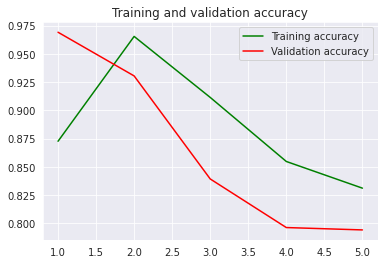

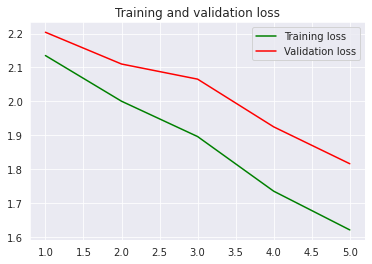

In [81]:
# Plot results
import matplotlib.pyplot as plt

accuracy = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
nlp_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ner-drone/ner_drone_250322_2209.h5')

y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(90, 46) (90, 46)
3/3 [==============================] - 1s 55ms/step - loss: 0.8655 - accuracy: 0.7558


[0.8655270934104919, 0.7557970881462097]

In [83]:
y_pred = nlp_model.predict(test_tokens)

In [84]:
y_pred = np.argmax(y_pred, axis=-1)

In [85]:
y_test_list = []
y_pred_list = []
for row in range(0, y_test.shape[0]):
  y_pred_list = np.concatenate((y_pred_list, y_pred[row]), axis=0)
  y_test_list = np.concatenate((y_test_list, y_test[row]), axis=0)
  # y_test_list = y_test_list + y_test[row]

In [86]:
data_prediction = pd.DataFrame({'actual_class': y_test_list, 'predicted_class': y_pred_list})
data_prediction['actual_class'] = data_prediction['actual_class'].map(idx2tag)
data_prediction['predicted_class'] = data_prediction['predicted_class'].map(idx2tag)

In [87]:
data_prediction

,actual_class,predicted_class
0,B-ACT,I-CMP
1,I-ACT,I-CMP
2,O,I-STE
3,O,I-STE
4,O,O
...,...,...
4135,O,O
4136,O,O
4137,O,O
4138,O,O


In [88]:
confusion_matrix = pd.crosstab(data_prediction['predicted_class'], data_prediction['actual_class'])
confusion_matrix

actual_class,B-ACT,B-CMP,B-FNC,B-ISS,B-STE,I-ACT,I-CMP,I-FNC,I-ISS,I-STE,O
predicted_class,,,,,,,,,,,
B-CMP,13,25,12,7,0,0,2,5,10,0,265
B-ISS,5,9,0,2,0,0,0,0,1,0,107
B-STE,1,2,1,1,0,0,0,0,1,0,40
I-CMP,6,14,4,4,1,1,8,1,1,0,87
I-ISS,1,2,0,3,1,0,0,0,2,2,14
I-STE,7,0,0,0,7,0,0,1,2,7,370
O,0,0,0,0,0,0,0,0,0,0,3085


In [89]:
from sklearn.metrics import classification_report

In [90]:
pd.DataFrame(classification_report(data_prediction['actual_class'], data_prediction['predicted_class'], output_dict=True)).T

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
B-ACT,0.000000,0.000000,0.000000,33.000000
B-CMP,0.073746,0.480769,0.127877,52.000000
B-FNC,0.000000,0.000000,0.000000,17.000000
B-ISS,0.016129,0.117647,0.028369,17.000000
B-STE,0.000000,0.000000,0.000000,9.000000
I-ACT,0.000000,0.000000,0.000000,1.000000
I-CMP,0.062992,0.800000,0.116788,10.000000
I-FNC,0.000000,0.000000,0.000000,7.000000
I-ISS,0.080000,0.117647,0.095238,17.000000
I-STE,0.017766,0.777778,0.034739,9.000000
